In [ ]:
# this is just to change the presentation style... Please ignore!
from IPython.display import display, HTML
display(HTML("""<style>
.cm-line { font-size: large !important; }
.dataframe tbody tr th { font-size: large !important; }
.dataframe tbody tr { font-size: large !important; }
.dataframe thead th { font-size: large !important; }
.dataframe thead { font-size: large !important; }
</style>"""))

from pymoo.config import Config
Config.warnings['not_compiled'] = False

# Pymoo (https://pymoo.org/)

![https://pymoo.org/_static/header.jpg](https://pymoo.org/_static/header.jpg)

In [ ]:
import pymoo
pymoo.__version__

Alternatives: [DEAP](https://deap.readthedocs.io/en/master/) & [jMetalPy](https://github.com/jMetal/jMetalPy)

# Create an example problem

In [ ]:
# From https://pymoo.org/problems/definition.html 
import numpy as np
from pymoo.core.problem import Problem

class SphereWithConstraint(Problem):
    def __init__(self):
        super().__init__(n_var=10, n_obj=1, n_ieq_constr=1, xl=0.0, xu=1.0)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = np.sum((x - 0.5) ** 2, axis=1)
        out["G"] = 0.1 - out["F"]


# For now, we import one...

In [ ]:
from pymoo.problems import get_problem
from pymoo.util.plotting import plot

problem = get_problem("zdt1")
plot(problem.pareto_front(), no_fill=True)

# Define the GA

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Run Minimization

In [ ]:
from pymoo.optimize import minimize
from pymoo.termination import get_termination

res = minimize(problem,
               algorithm,
               get_termination("n_gen", 40),
               seed=1,
               save_history=True,
               verbose=True)

# Analysis

#### Generational Distance

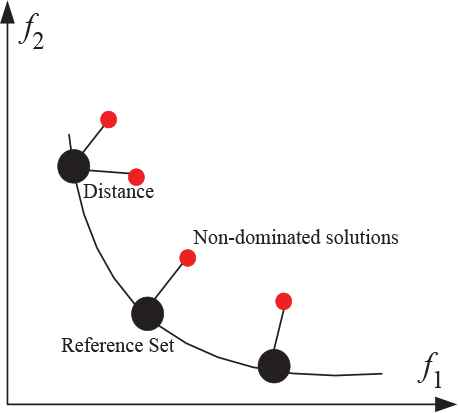

#### Inverted Generational Distance
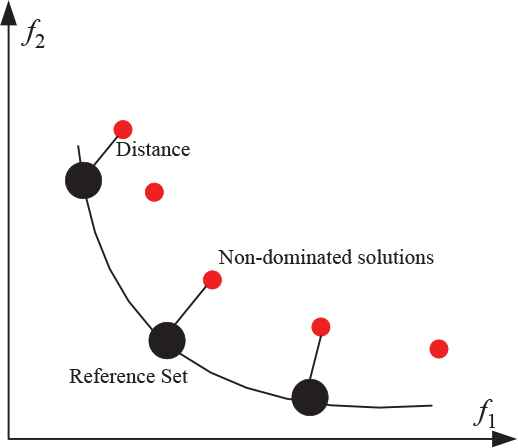

*Source: https://www.atlantis-press.com/journals/ijcis/125912233/view*

In [ ]:
import pandas as pd
# define Performance Indicator functions
from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
pareto_front = problem.pareto_front()
gd =  GD(pareto_front)
igd = IGD(pareto_front)

# pymoo's history is a list of algorithm objects...
pis = [[gd(alg.result().F), igd(alg.result().F)] for alg in res.history]
 
pd.DataFrame(pis, columns=["GD", "IGD"]).plot(figsize=(20, 5))

# How do we know which of two algorithms is better?

In [ ]:
algorithm1 = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

In [ ]:
algorithm2 = NSGA2(
    pop_size=20,  # <== HERE
    n_offsprings=12,  # <== HERE
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# Run them X times (e.g. X = 10)
Note, typically N <= 30 suffices

In [ ]:
alg1_res = []
for idx in range(10):
    res = minimize(problem,
               algorithm1,
               get_termination("n_gen", 40),
               seed=idx * 100,
               save_history=True,
               verbose=False)
    alg1_res.append(res)

In [ ]:
alg2_res = []
for idx in range(10):
    res = minimize(problem,
               algorithm2,
               get_termination("n_gen", 40),
               seed=idx * 100,
               save_history=True,
               verbose=False)
    alg2_res.append(res)

# Extract GD & IGD

In [ ]:
[[gd(res.F), igd(res.F)] for res in alg1_res]

In [ ]:
[[gd(res.F), igd(res.F)] for res in alg2_res]

# Plot the values

In [ ]:
df = pd.DataFrame([[gd(res1.F), gd(res2.F), igd(res1.F), igd(res2.F)] for res1, res2 in zip(alg1_res, alg2_res)],
             columns=["Alg1-GD", "Alg2-GD","Alg1-IGD","Alg2-IGD"])

In [ ]:
df

In [ ]:
_ = df[["Alg1-GD","Alg2-GD"]].plot()

In [ ]:
_ = df[["Alg1-IGD","Alg2-IGD"]].plot()

# A more statistical plot ...

In [ ]:
_ = df.boxplot()

## Statistical Analysis
- Use [Mann-Whitney *U* Test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) to compare whether two distributions are statistically the same
- We will use scipy's [`scipy.stats.mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) for it
    - Returns the p-value for the chosen __alternative__
- Use Kolmogorov-Smirnoff Test only for very large sample sizes (> 500)

In [ ]:
from scipy.stats import mannwhitneyu

mannwhitneyu(df["Alg1-GD"], df["Alg2-GD"])[1]

In [ ]:
mannwhitneyu(df["Alg1-IGD"], df["Alg2-IGD"])[1]

# Effect size

- e.g. using Vargha and Delaney's Â12
- Unfortunately no Python framework provides an implementation
- We use a version implemented in R, then ported to Python
- Source: https://gist.github.com/jacksonpradolima/f9b19d65b7f16603c837024d5f8c8a65

- <span style="color:red;">**FIRST, CHECK P-VALUE !!!!!**</span>

In [ ]:
from VD import VD_A
VD_A(df["Alg1-GD"].tolist(), df["Alg2-GD"].tolist())

In [ ]:
VD_A(df["Alg1-IGD"].tolist(), df["Alg2-IGD"].tolist())

# Questions ?